In [16]:
import pandas as pd

# File Path
file_path = 'C:/Users/TeddySong/Desktop/Project_4/clean_records.csv'

#Load Data
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head()


,_id,Address,Center Classification Date,City,Classification,Country,Postal Code,Recall Firm,Recall Initiation Date,State,Status,Termination Date,Days To Classify
0,675f4cb2583fb273abfea9c7,2610 Homestead Pl,2020-04-13,Rancho Dominguez,Class III,United States,90220-5610,"Organic By Nature, Inc.",2020-02-24,CA,Terminated,2021-02-02,49
1,675f4cb2583fb273abfea9c8,47 Bridgewater St # 57,2020-04-24,Brooklyn,Class III,United States,11222-3820,Rong Shing Trading NY Inc,2020-04-01,NY,Terminated,2021-03-18,23
2,675f4cb2583fb273abfea9c9,2959 Salinas Hwy,2022-02-22,Monterey,Class I,United States,93940-6400,Dole Fresh Vegetables Inc,2022-01-06,CA,Terminated,2022-03-22,47
3,675f4cb2583fb273abfea9ca,262 E Main St,2022-07-19,Lovell,Class II,United States,82431-2102,"Queen Bee Gardens, LLC",2022-04-28,WY,Terminated,2023-01-17,82
4,675f4cb2583fb273abfea9ce,1700 E Stroop Rd,2023-08-02,Dayton,Class II,United States,45429-5040,Cassanos Inc,2023-07-18,OH,Terminated,2023-09-27,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   _id                         848 non-null    object
 1   Address                     848 non-null    object
 2   Center Classification Date  848 non-null    object
 3   City                        848 non-null    object
 4   Classification              848 non-null    object
 5   Country                     848 non-null    object
 6   Postal Code                 848 non-null    object
 7   Recall Firm                 848 non-null    object
 8   Recall Initiation Date      848 non-null    object
 9   State                       848 non-null    object
 10  Status                      848 non-null    object
 11  Termination Date            848 non-null    object
 12  Days To Classify            848 non-null    int64 
dtypes: int64(1), object(12)
memory usage: 86.3+ KB
Non

C:\Users\TeddySong\AppData\Local\Temp\ipykernel_21724\945570397.py:7: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



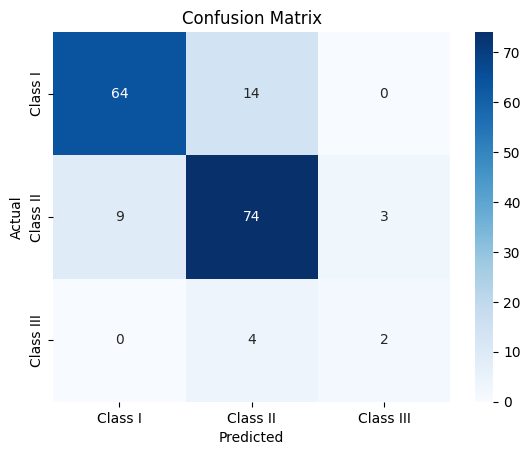

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}


Prediction Accuracy: 95.52%


In [17]:
# Data Exploration
print(df.info())  # Check the basic information of the dataset
print(df.describe())  # Check statistical summary
print(df.isnull().sum())  # Check for missing values

# Data Cleaning
df.fillna(method='ffill', inplace=True)  # Fill missing values with forward fill

# Convert date fields
df['Recall Initiation Date'] = pd.to_datetime(df['Recall Initiation Date'])

# Create new features: year and month
df['Year'] = df['Recall Initiation Date'].dt.year
df['Month'] = df['Recall Initiation Date'].dt.month

# Feature Selection and Processing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode categorical variables
label_enc = LabelEncoder()
df['State'] = label_enc.fit_transform(df['State'])
df['Country'] = label_enc.fit_transform(df['Country'])

# Map original class types to numbers and save mapping
class_mapping = {'Class I': 0, 'Class II': 1, 'Class III': 2}
reverse_mapping = {v: k for k, v in class_mapping.items()}

df['Classification'] = df['Classification'].map(class_mapping)  # Encode target variable

# Standardize numerical variables
scaler = StandardScaler()
df['Days To Classify'] = scaler.fit_transform(df[['Days To Classify']])

# Select features and target variable
X = df[['State', 'Country', 'Days To Classify', 'Year', 'Month']]
y = df['Classification']

# Split the dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Output the best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Save the Model
import joblib
joblib.dump(model, 'classification_model.pkl')

# Add predictions back to the dataframe with original class labels
df['Prediction'] = model.predict(X)
df['Prediction Label'] = df['Prediction'].map(reverse_mapping)
df['Actual Label'] = df['Classification'].map(reverse_mapping)

# Plot Line Chart for Predictions Over Time
import plotly.express as px

df['Prediction'] = model.predict(X)
df['Prediction Label'] = df['Prediction'].map(reverse_mapping)  # Predict
df['Actual Label'] = df['Classification'].map(reverse_mapping)  # Actual

# Plot
fig = px.scatter(
    df.sort_values(by='Recall Initiation Date'),
    x='Recall Initiation Date',
    y='Prediction Label',
    color='Actual Label',
    title='Scatter Plot of Predictions Over Time',
    labels={
        'Prediction Label': 'Predicted Class',
        'Actual Label': 'Actual Class',
        'Recall Initiation Date': 'Date'
    },
    symbol='Actual Label',  
    hover_data=['Actual Label', 'Prediction Label']  
)

fig.show()

from sklearn.metrics import accuracy_score

# Accurancy
accuracy = accuracy_score(df['Classification'], df['Prediction'])
print(f"Prediction Accuracy: {accuracy:.2%}")


